In [16]:

import json
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix
import numpy as np
import os
from ast import literal_eval
import matplotlib.pyplot as plt

In [17]:
def safe_literal_eval(val):
    """Safely evaluate a string to a Python object if it's not already a list."""
    if isinstance(val, str):
        return literal_eval(val)
    return val


In [18]:
def load_label_mapping(meta_json_path):
    with open(meta_json_path, 'r') as file:
        meta_data = json.load(file)
    int_to_label = {int(k): v for k, v in meta_data['Int_to_label'].items()}
    return int_to_label

In [19]:
def get_true_pred(df, threshold=0.5):
    # Apply safe literal evaluation to ensure correct conversion
    df['prediction'] = df['prediction'].apply(safe_literal_eval)
    df['label'] = df['label'].apply(safe_literal_eval)
    df['probability'] = df['probability'].apply(safe_literal_eval)

    if threshold != 0.5:
        # Update predictions based on the new threshold
        df['prediction'] = df['probability'].apply(lambda x: [1 if i > threshold else 0 for i in x])

    # Convert lists to numpy arrays
    y_true = np.stack(df['label'].values)
    y_pred = np.stack(df['prediction'].values)

    return y_true, y_pred


In [20]:
def calculate_metrics(df, label_mapping, threshold=0.5):
    # Convert predictions and labels from string to numpy array safely
    y_true, y_pred = get_true_pred(df, threshold)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='micro')
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')

    return accuracy, f1, precision, recall

In [21]:
def display_confusion_matrix(df, label_mapping):
    labels = list(label_mapping.keys())
    
    y_true = np.stack(df['label'].values)
    y_pred = np.stack(df['prediction'].values)
    
    mcm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
    
    for i, label in label_mapping.items():
        print(f'Confusion Matrix for {label}:')
        print(mcm[i])
        print()

In [22]:
def get_meta_json_path(params_json_path):
    with open(params_json_path, 'r') as file:
        params_data = json.load(file)
    data_path = params_data['data']
    # remove /data/ because we are already in the data directory
    data_path = data_path.lstrip('data/')
    print(data_path)
    meta_json_path = os.path.join(data_path, 'meta.json')
    return meta_json_path

In [23]:
def load_label_mapping_from_params(params_json_path):
    meta_json_path = get_meta_json_path(params_json_path)
    return load_label_mapping(meta_json_path)


In [26]:
def plot_threshold_metrics(df):
    """
    Plots precision, recall, and F1 score against different thresholds to help decide the best threshold.

    Parameters:
    - y_true: ndarray of shape (n_samples, n_classes), true binary labels.
    - y_probs: ndarray of shape (n_samples, n_classes), predicted probabilities.
    - thresholds: list or ndarray, thresholds to evaluate. If None, defaults to np.arange(0.0, 1.05, 0.05).
    """
    thresholds = np.arange(0.0, 1.05, 0.05)
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracy_scores = []

    for threshold in thresholds:
        y_true, y_pred = get_true_pred(df, threshold)
        # Calculate precision, recall, and F1 score
        precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
        
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_scores, label='Precision', marker='o')
    plt.plot(thresholds, recall_scores, label='Recall', marker='o')
    plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
    plt.plot(thresholds, accuracy_scores, label='Accuracy', marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    # add threshold values to x-axis
    plt.xticks(np.arange(0.0, 1.05, 0.05))
    plt.title('Precision, Recall, and F1 Score at Different Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

prepared_data/substances


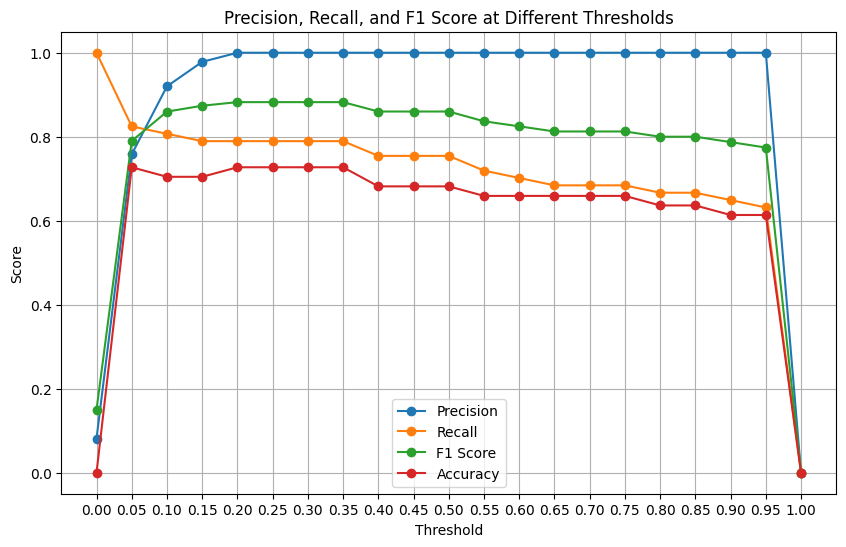

Accuracy: 0.7045454545454546
F1 Score: 0.8598130841121495
Precision: 0.92
Recall: 0.8070175438596491
Confusion Matrix for Ketamine:
[[27  1]
 [ 0 16]]

Confusion Matrix for S-Ketamine:
[[41  0]
 [ 0  3]]

Confusion Matrix for R-Ketamine:
[[44  0]
 [ 0  0]]

Confusion Matrix for MDMA:
[[30  1]
 [ 0 13]]

Confusion Matrix for LSD:
[[39  1]
 [ 1  3]]

Confusion Matrix for Psilocybin:
[[37  0]
 [ 0  7]]

Confusion Matrix for Psychedelic mushrooms:
[[44  0]
 [ 0  0]]

Confusion Matrix for Ayahuasca:
[[43  0]
 [ 0  1]]

Confusion Matrix for DMT:
[[43  0]
 [ 0  1]]

Confusion Matrix for 5-MeO-DMT:
[[44  0]
 [ 0  0]]

Confusion Matrix for Mescaline:
[[43  0]
 [ 1  0]]

Confusion Matrix for Ibogaine:
[[44  0]
 [ 0  0]]

Confusion Matrix for Salvinorin A:
[[43  0]
 [ 0  1]]

Confusion Matrix for Combination Therapy:
[[36  0]
 [ 8  0]]

Confusion Matrix for Analogue:
[[44  0]
 [ 0  0]]

Confusion Matrix for Unknown:
[[41  1]
 [ 1  1]]



In [27]:
# Example usage
params_json_path = '../model/experiments/pubmedbert_substances_20240902/params.json'
predictions_csv_path = '../model/experiments/pubmedbert_substances_20240902/predictions.csv'

# Load label mapping using the params.json path
label_mapping = load_label_mapping_from_params(params_json_path)

# Load the predictions CSV
df = pd.read_csv(predictions_csv_path)

# Plot precision, recall, and F1 score against different thresholds
plot_threshold_metrics(df)

# Calculate metrics
accuracy, f1, precision, recall = calculate_metrics(df, label_mapping, threshold=0.1)
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Display confusion matrix
display_confusion_matrix(df, label_mapping)